# Experiments with real data (dubai houses)

https://www.kaggle.com/datasets/dataregress/dubai-properties-dataset

## Requirements

In [1]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'dubai_houses_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_dubai_houses import get_config as get_config_exp_1_dubai_houses
from config_experiment_3_dubai_houses import get_config as get_config_exp_3_dubai_houses
from config_experiment_4_dubai_houses import get_config as get_config_exp_4_dubai_houses

pl.Config.set_tbl_rows(12)

polars.config.Config

## Data exploration


### Conceptual description

TO DO

### Data reading

In [3]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

df, X, y, p1, p2, p3, n_clusters, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

### Data view

In [3]:
X.head()


latitude,longitude,price,size_in_sqft,price_per_sqft,balcony,barbecue_area,private_pool,private_garden,no_of_bedrooms,no_of_bathrooms
f64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64
25.113208,55.138932,2700000,1079,2502.32,1,1,0,0,1,2
25.106809,55.151201,2850000,1582,1801.52,1,0,0,0,2,2
25.063302,55.137728,1150000,1951,589.44,1,0,0,0,3,5
25.227295,55.341761,2850000,2020,1410.89,1,0,0,0,2,3
25.114275,55.139764,1729200,507,3410.65,0,0,0,0,0,1


In [4]:
X.shape

(1905, 11)

In [5]:
y.head(5)

quality
i64
1
1
1
0
1


In [6]:
y.shape

(1905,)

In [7]:
n_clusters

2

In [8]:
print(p1, p2, p3)

5 4 2


In [9]:
encoding

{'quality': {'Low': 0, 'Medium': 1, 'High': 1, 'Ultra': 1},
 'balcony': {False: 0, True: 1},
 'barbecue_area': {False: 0, True: 1},
 'private_pool': {False: 0, True: 1},
 'private_garden': {False: 0, True: 1}}

In [10]:
quant_predictors

['latitude', 'longitude', 'price', 'size_in_sqft', 'price_per_sqft']

In [11]:
binary_predictors

['balcony', 'barbecue_area', 'private_pool', 'private_garden']

In [12]:
multiclass_predictors

['no_of_bedrooms', 'no_of_bathrooms']

### Data description

In [13]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [14]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
latitude,723,0.0,25.116538,0.062647,24.865992,25.047032,25.072791,25.0967,25.18813,25.200879,25.273623,2.044642,0.262948,0.000525
longitude,722,0.0,55.212338,0.068794,55.069311,55.136449,55.145389,55.207506,55.271797,55.288017,55.441623,2.338011,0.44398,0.0
price,821,0.0,2085829.873491,2913199.961504,220000.0,610502.0,890000.0,1400000.0,2200000.0,3499999.0,35000000.0,51.725286,6.142561,0.067192
size_in_sqft,1121,0.0,1417.050394,891.487639,294.0,666.0,840.0,1271.0,1703.0,2281.0,9576.0,17.23589,2.905285,0.046194
price_per_sqft,1784,0.0,1327.243785,668.473559,361.87,699.61,870.92,1169.59,1622.5,2073.17,4805.87,7.781859,1.840715,0.043045


In [15]:
cat_summary

,n_unique,perc_nan,mode
balcony,2,0.0,1
barbecue_area,2,0.0,0
private_pool,2,0.0,0
private_garden,2,0.0,0
no_of_bedrooms,6,0.0,2
no_of_bathrooms,6,0.0,2


In [16]:
y.describe()

statistic,value
str,f64
"""count""",1905.0
"""null_count""",0.0
"""mean""",0.714436
"""std""",0.451801
"""min""",0.0
"""25%""",0.0
"""50%""",1.0
"""75%""",1.0
"""max""",1.0


In [17]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = np.round(counts/len(y), 2)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.29, 1: 0.71}


In [18]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""latitude""",24.899783,25.361138,1,1904,0.000525,0.999475
"""longitude""",54.955777,55.461409,0,1905,0.0,1.0
"""price""",-1.075e6,4.165e6,128,1777,0.067192,0.932808
"""size_in_sqft""",-454.5,2997.5,88,1817,0.046194,0.953806
"""price_per_sqft""",-256.45,2749.87,82,1823,0.043045,0.956955


In [19]:
outliers_df['prop_outliers'].mean()

0.03139107611548556

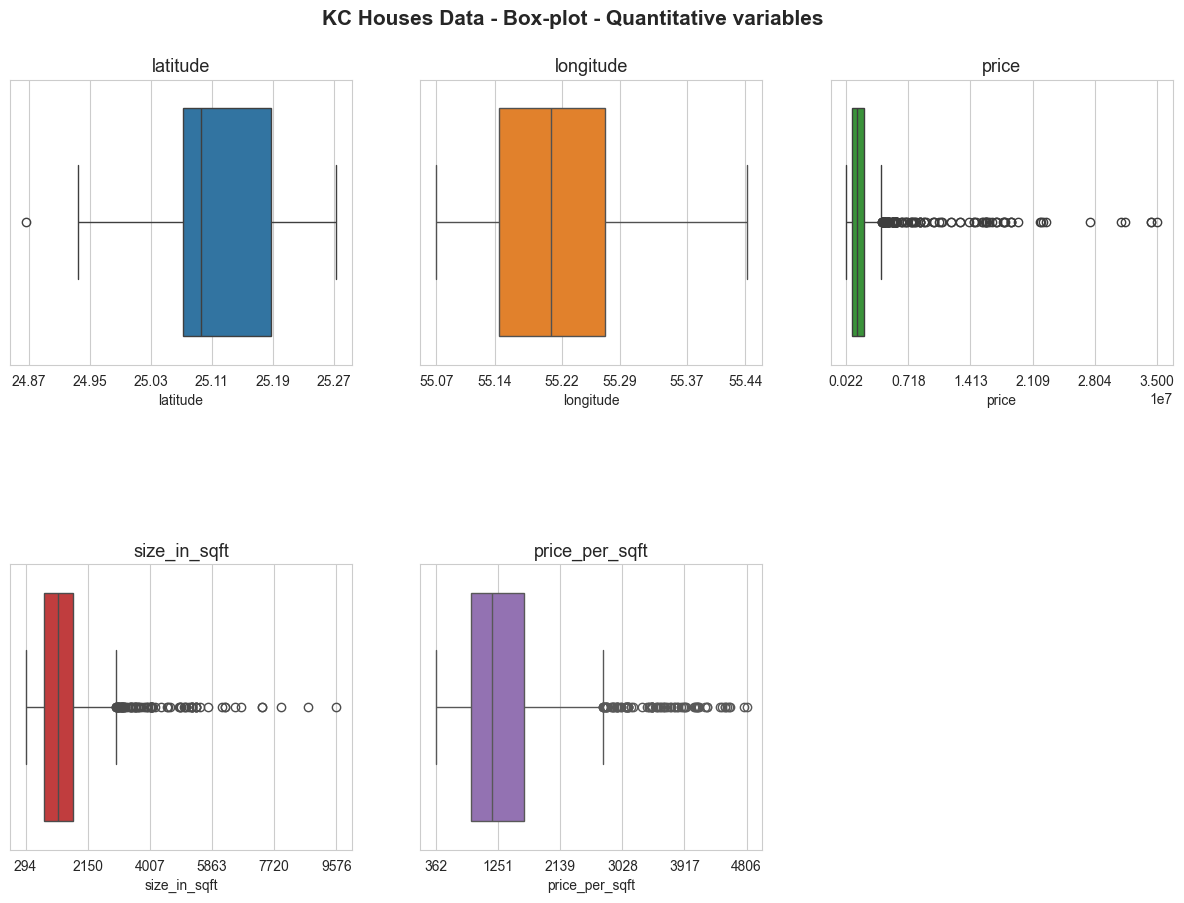

In [20]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='KC Houses Data - Box-plot - Quantitative variables', 
               figsize=(15,10), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=15, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.2, 
               title_weight='bold',
               subtitles_fontsize=13, 
               xlabel_size=10,
            )

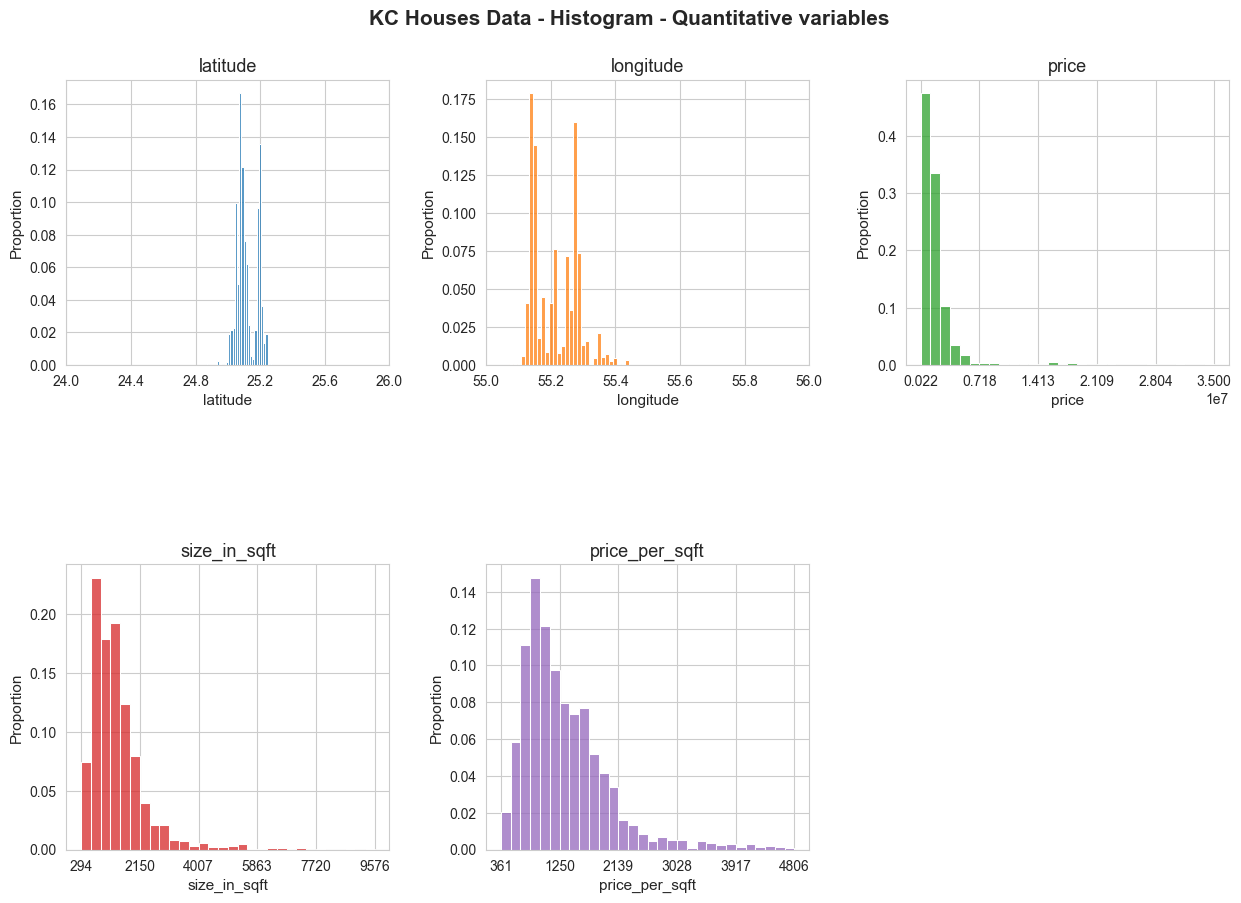

In [21]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, 
                 title='KC Houses Data - Histogram - Quantitative variables', 
                 figsize=(15,10), quant_col_names=quant_predictors, 
                 n_xticks=6, title_fontsize=15, subtitles_weight=None,
                 subtitles_fontsize=13, save=False, file_name='', x_rotation=0, title_height=0.95,
                 style='whitegrid', hspace=0.7, wspace=0.3, n_round_xticks=1)

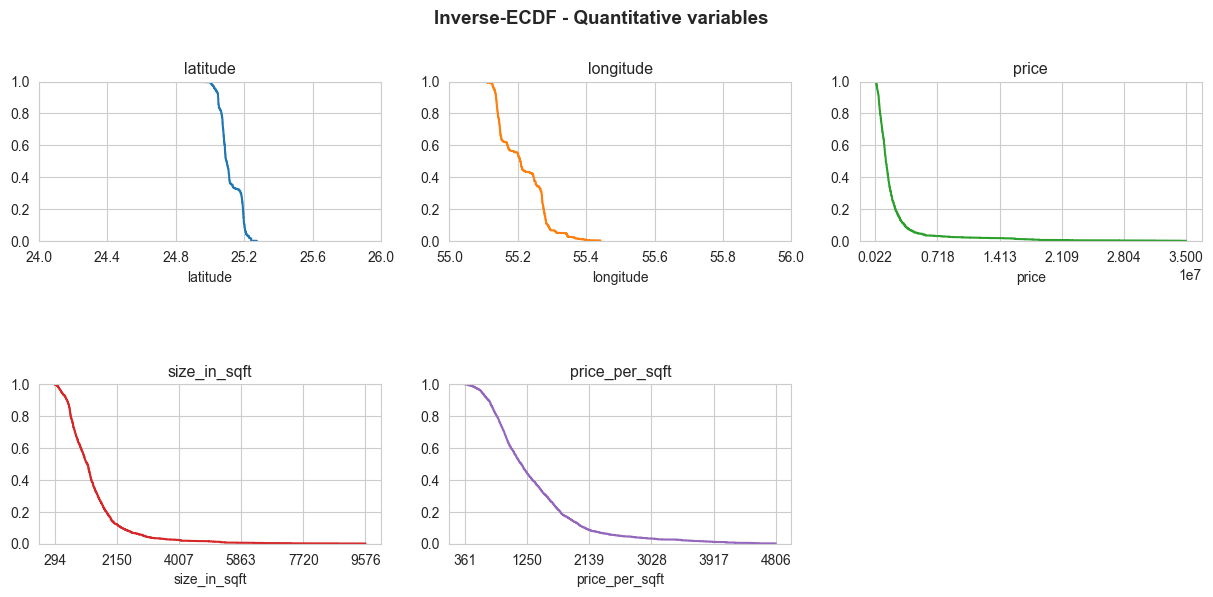

In [22]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

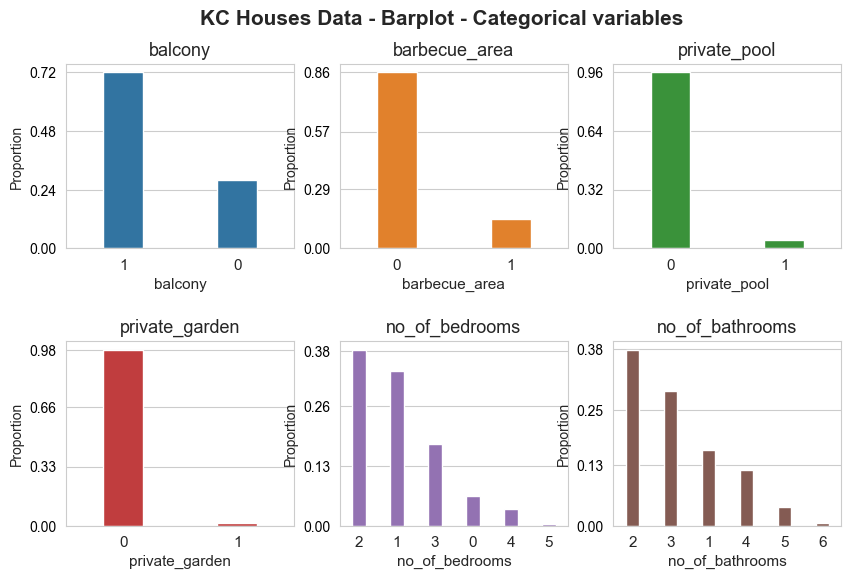

In [23]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='KC Houses Data - Barplot - Categorical variables', 
               figsize=(10,6), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=15, 
               subtitles_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.97,
               style='whitegrid', 
               hspace=0.5, 
               wspace=0.2, 
               title_weight='bold', 
               subtitles_weight=None, 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=11, 
               xticks_size=11)

In [24]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,latitude,longitude,price,size_in_sqft,price_per_sqft
latitude,1.000000,0.605875,0.206775,0.137518,0.409887
longitude,0.605875,1.000000,-0.015395,-0.066657,0.020590
price,0.206775,-0.015395,1.000000,0.808595,0.705538
size_in_sqft,0.137518,-0.066657,0.808595,1.000000,0.344276
price_per_sqft,0.409887,0.020590,0.705538,0.344276,1.000000


In [25]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.3
Proportion of pair-wise correlations in [0.30, 0.60]:  0.2
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.5


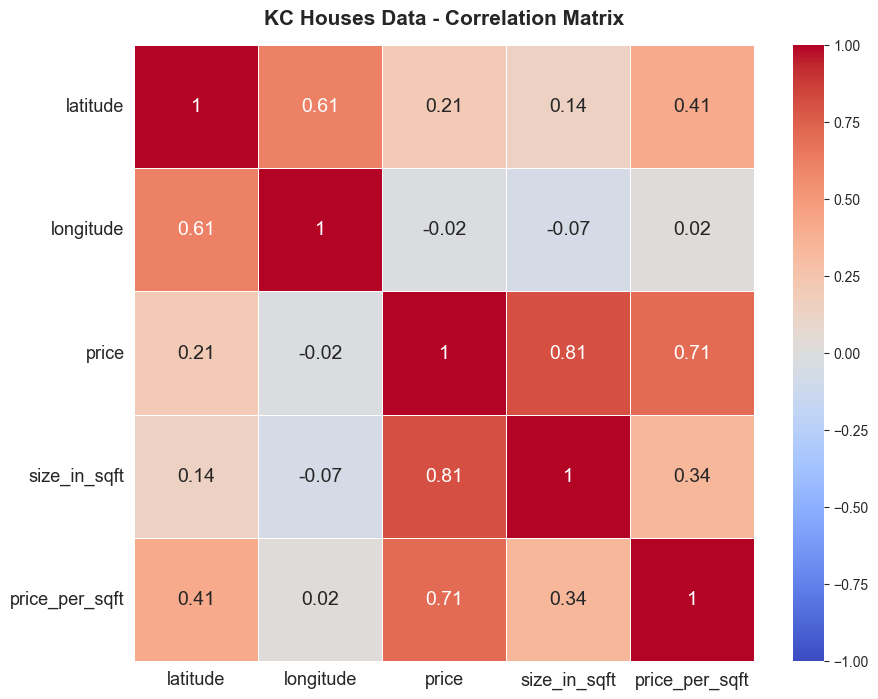

In [26]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(10,8))
sns.heatmap(    
    corr, 
    annot=True,                 # Muestra los valores dentro de las celdas
    cmap="coolwarm",            # Paleta de colores
    vmin=-1, vmax=1,             # Escala del colorbar
    linewidths=0.5,             # Líneas entre celdas
    annot_kws={"size": 14}      # Tamaño del texto dentro de las celdas
)

# Personalizar etiquetas
plt.xticks(fontsize=13)         # Tamaño etiquetas eje X
plt.yticks(fontsize=13, rotation=0)  # Tamaño etiquetas eje Y (sin rotación)
plt.title("KC Houses Data - Correlation Matrix", fontsize=15, fontweight='bold', y=1.02)
plt.show()


## Experiment 1


In [27]:
run_experiment_1 = True

In [28]:
if run_experiment_1: 
        
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'dubai_houses')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251018_215241'

    config_exp_1 = get_config_exp_1_dubai_houses()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [ ]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score #accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_dubai_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations:  12 mins

chunks:   0%|          | 0/20 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427, 53377, 34937]
random_state: 6863
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 35084
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 11427
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0

chunks:   5%|▌         | 1/20 [00:37<11:46, 37.21s/chunks]

len y_pred: 2
random_state_chunk: [14116, 5000, 49692, 70281, 73704]
random_state: 14116
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 5000
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 49692
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  10%|█         | 2/20 [01:09<10:18, 34.37s/chunks]

len y_pred: 2
random_state_chunk: [43541, 44669, 6802, 20927, 17702]
random_state: 43541
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 44669
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 6802
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  15%|█▌        | 3/20 [01:41<09:27, 33.40s/chunks]

len y_pred: 2
random_state_chunk: [44199, 73526, 43751, 91971, 32134]
random_state: 44199
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 73526
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 43751
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  20%|██        | 4/20 [02:14<08:46, 32.92s/chunks]

len y_pred: 2
random_state_chunk: [21466, 218, 57183, 11483, 78328]
random_state: 21466
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 218
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 57183
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sa

chunks:  25%|██▌       | 5/20 [02:46<08:12, 32.84s/chunks]

len y_pred: 2
random_state_chunk: [49492, 9158, 864, 41347, 95949]
random_state: 49492
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 9158
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 864
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_samp

chunks:  30%|███       | 6/20 [03:19<07:38, 32.73s/chunks]

len y_pred: 2
random_state_chunk: [58762, 13374, 5752, 12158, 87443]
random_state: 58762
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 13374
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 5752
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  35%|███▌      | 7/20 [03:52<07:07, 32.85s/chunks]

len y_pred: 2
random_state_chunk: [18635, 16547, 2783, 38247, 56444]
random_state: 18635
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 16547
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 2783
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  40%|████      | 8/20 [04:24<06:31, 32.59s/chunks]

len y_pred: 2
random_state_chunk: [75157, 62511, 34776, 61511, 4816]
random_state: 75157
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 62511
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 34776
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac

chunks:  45%|████▌     | 9/20 [05:05<06:27, 35.24s/chunks]

len y_pred: 2
random_state_chunk: [39989, 45018, 68376, 63302, 27113]
random_state: 39989
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 45018
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 68376
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  50%|█████     | 10/20 [05:47<06:13, 37.34s/chunks]

len y_pred: 2
random_state_chunk: [79810, 83723, 69084, 74031, 41322]
random_state: 79810
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 83723
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 69084
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  55%|█████▌    | 11/20 [06:32<05:56, 39.66s/chunks]

len y_pred: 2
random_state_chunk: [1644, 52197, 84692, 67207, 56935]
random_state: 1644
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 52197
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 84692
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  60%|██████    | 12/20 [07:15<05:26, 40.79s/chunks]

len y_pred: 2
random_state_chunk: [89762, 70584, 83670, 87380, 78185]
random_state: 89762
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 70584
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 83670
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  65%|██████▌   | 13/20 [07:57<04:47, 41.07s/chunks]

len y_pred: 2
random_state_chunk: [63718, 68237, 87617, 54984, 49089]
random_state: 63718
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 68237
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 87617
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  70%|███████   | 14/20 [08:35<04:01, 40.18s/chunks]

len y_pred: 2
random_state_chunk: [66855, 4173, 98850, 84600, 23784]
random_state: 66855
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 4173
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 98850
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  75%|███████▌  | 15/20 [09:16<03:21, 40.34s/chunks]

len y_pred: 2
random_state_chunk: [95135, 10827, 63819, 86255, 34326]
random_state: 95135
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 10827
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 63819
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  80%|████████  | 16/20 [09:54<02:38, 39.60s/chunks]

len y_pred: 2
random_state_chunk: [22298, 43896, 44160, 72640, 51274]
random_state: 22298
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 43896
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 44160
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
fra

chunks:  85%|████████▌ | 17/20 [10:32<01:57, 39.14s/chunks]

len y_pred: 2
random_state_chunk: [9606, 94779, 59869, 50810, 75126]
random_state: 9606
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 94779
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 59869
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  90%|█████████ | 18/20 [11:15<01:20, 40.35s/chunks]

len y_pred: 2
random_state_chunk: [44054, 2137, 24780, 76834, 11554]
random_state: 44054
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 2137
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 24780
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks:  95%|█████████▌| 19/20 [11:54<00:40, 40.01s/chunks]

len y_pred: 2
random_state_chunk: [82354, 47646, 1681, 46126, 30032]
random_state: 82354
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 47646
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 1681
frac_sample_size: 0.05
len y_pred: 2
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_

chunks: 100%|██████████| 20/20 [12:36<00:00, 37.80s/chunks]

len y_pred: 2


In [30]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'dubai_houses')
    file_id = '20251018_215241'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_dubai_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_dubai_houses_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [63]:
# Open merged/joined results 

file_id = '20251018_215241'
results_filename = f'results_exp_1_dubai_houses_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'dubai_houses')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [64]:
pivoted_results = get_pivoted_results(
    results=results, 
    iterable=config_exp_1['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=config_exp_1['frac_sample_sizes']
)

In [33]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

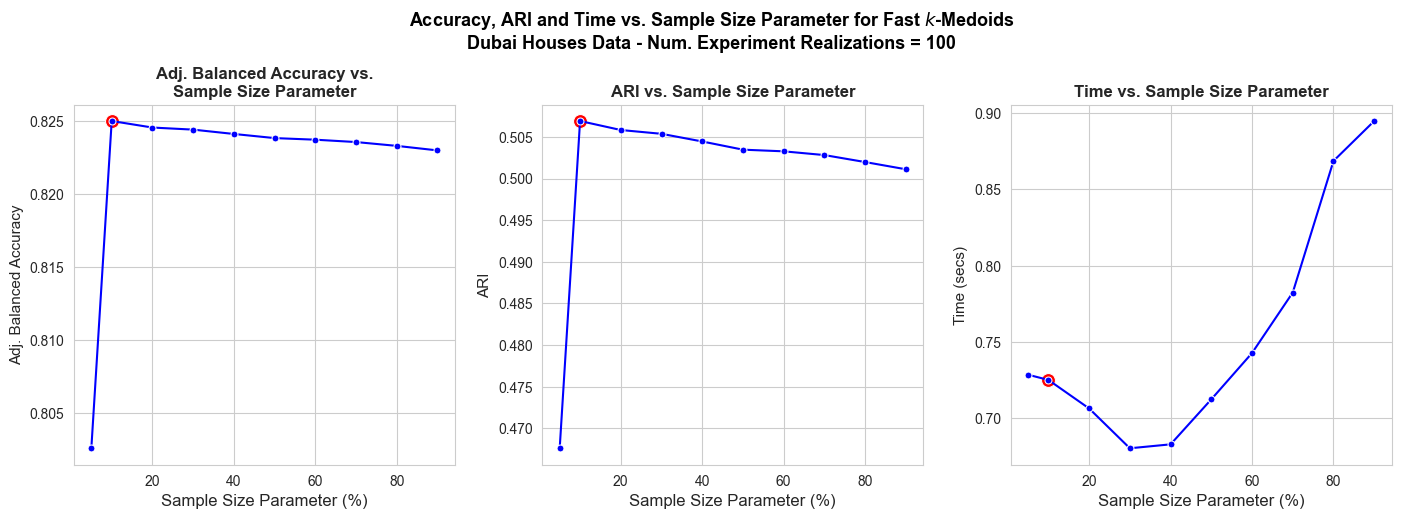

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Balanced Accuracy vs.\nSample Size Parameter', size=12, weight='bold')
axes[0].set_ylabel('Adj. Balanced Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size Parameter', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size Parameter', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=12)

#plt.tight_layout()
plt.subplots_adjust(top=0.83) 
plt.suptitle('Accuracy, ARI and Time vs. Sample Size Parameter for Fast $k$-Medoids\nDubai Houses Data - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_dubai_houses_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [65]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.05,0.728610,0.802566,0.467596
0.10,0.725183,0.825027,0.506913
0.20,0.706494,0.824578,0.505832
0.30,0.680417,0.824435,0.505375
0.40,0.682998,0.824137,0.504454
0.50,0.712496,0.823854,0.503470
0.60,0.742827,0.823744,0.503270
0.70,0.782460,0.823582,0.502821
0.80,0.868640,0.823320,0.501982


In [66]:
print(best_frac_sample_size)

0.1



## Experiment 3


In [37]:
run_experiment_3 = True

In [38]:
if run_experiment_3: 

    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'dubai_houses')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251018_215622'

    config_exp_3 = get_config_exp_3_dubai_houses()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [ ]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score # accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_dubai_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 171 mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427]
random_state: 6863
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


random_state: 35084
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


random_state: 11427
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.9


chunks:   3%|▎         | 1/34 [05:04<2:47:22, 304.30s/chunks]

random_state_chunk: [53377, 34937, 14116]
random_state: 53377
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


random_state: 34937
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


random_state: 14116
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.9


chunks:   6%|▌         | 2/34 [10:03<2:40:45, 301.41s/chunks]

random_state_chunk: [5000, 49692, 70281]
random_state: 5000
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


random_state: 49692
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


random_state: 70281
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


frac_sample_size: 0.9


chunks:   9%|▉         | 3/34 [15:09<2:36:45, 303.39s/chunks]

random_state_chunk: [73704, 43541, 44669]
random_state: 73704
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


random_state: 43541
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


random_state: 44669
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


frac_sample_size: 0.9


chunks:  12%|█▏        | 4/34 [20:20<2:33:17, 306.58s/chunks]

random_state_chunk: [6802, 20927, 17702]
random_state: 6802
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


random_state: 20927
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


random_state: 17702
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


frac_sample_size: 0.9


chunks:  15%|█▍        | 5/34 [25:36<2:29:41, 309.72s/chunks]

random_state_chunk: [44199, 73526, 43751]
random_state: 44199
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


random_state: 73526
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


random_state: 43751
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.9


chunks:  18%|█▊        | 6/34 [30:41<2:23:53, 308.35s/chunks]

random_state_chunk: [91971, 32134, 21466]
random_state: 91971
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


random_state: 32134
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


random_state: 21466
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.9


chunks:  21%|██        | 7/34 [35:51<2:18:57, 308.79s/chunks]

random_state_chunk: [218, 57183, 11483]
random_state: 218
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


random_state: 57183
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


random_state: 11483
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.9


chunks:  24%|██▎       | 8/34 [41:04<2:14:18, 309.96s/chunks]

random_state_chunk: [78328, 49492, 9158]
random_state: 78328
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


random_state: 49492
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


random_state: 9158
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.9


chunks:  26%|██▋       | 9/34 [46:14<2:09:14, 310.17s/chunks]

random_state_chunk: [864, 41347, 95949]
random_state: 864
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


random_state: 41347
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


random_state: 95949
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


frac_sample_size: 0.9


chunks:  29%|██▉       | 10/34 [51:19<2:03:25, 308.55s/chunks]

random_state_chunk: [58762, 13374, 5752]
random_state: 58762
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


random_state: 13374
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


random_state: 5752
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.9


chunks:  32%|███▏      | 11/34 [56:25<1:58:01, 307.89s/chunks]

random_state_chunk: [12158, 87443, 18635]
random_state: 12158
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


random_state: 87443
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


random_state: 18635
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


frac_sample_size: 0.9


chunks:  35%|███▌      | 12/34 [1:01:31<1:52:36, 307.12s/chunks]

random_state_chunk: [16547, 2783, 38247]
random_state: 16547
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


random_state: 2783
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


random_state: 38247
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.9


chunks:  38%|███▊      | 13/34 [1:06:28<1:46:24, 304.02s/chunks]

random_state_chunk: [56444, 75157, 62511]
random_state: 56444
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


random_state: 75157
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


random_state: 62511
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.9


chunks:  41%|████      | 14/34 [1:11:42<1:42:21, 307.10s/chunks]

random_state_chunk: [34776, 61511, 4816]
random_state: 34776
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


random_state: 61511
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


random_state: 4816
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


frac_sample_size: 0.9


chunks:  44%|████▍     | 15/34 [1:16:39<1:36:19, 304.19s/chunks]

random_state_chunk: [39989, 45018, 68376]
random_state: 39989
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


random_state: 45018
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


random_state: 68376
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


frac_sample_size: 0.9


chunks:  47%|████▋     | 16/34 [1:21:48<1:31:41, 305.62s/chunks]

random_state_chunk: [63302, 27113, 79810]
random_state: 63302
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


random_state: 27113
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


random_state: 79810
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


frac_sample_size: 0.9


chunks:  50%|█████     | 17/34 [1:26:50<1:26:14, 304.40s/chunks]

random_state_chunk: [83723, 69084, 74031]
random_state: 83723
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


random_state: 69084
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


random_state: 74031
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


frac_sample_size: 0.9


chunks:  53%|█████▎    | 18/34 [1:32:30<1:24:00, 315.06s/chunks]

random_state_chunk: [41322, 1644, 52197]
random_state: 41322
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


random_state: 1644
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


random_state: 52197
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


frac_sample_size: 0.9


chunks:  56%|█████▌    | 19/34 [1:38:53<1:23:51, 335.44s/chunks]

random_state_chunk: [84692, 67207, 56935]
random_state: 84692
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


random_state: 67207
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


random_state: 56935
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.9


chunks:  59%|█████▉    | 20/34 [1:44:33<1:18:37, 336.98s/chunks]

random_state_chunk: [89762, 70584, 83670]
random_state: 89762
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


random_state: 70584
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


random_state: 83670
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.9


chunks:  62%|██████▏   | 21/34 [1:49:48<1:11:35, 330.44s/chunks]

random_state_chunk: [87380, 78185, 63718]
random_state: 87380
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


random_state: 78185
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


random_state: 63718
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.9


chunks:  65%|██████▍   | 22/34 [1:54:56<1:04:44, 323.67s/chunks]

random_state_chunk: [68237, 87617, 54984]
random_state: 68237
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


random_state: 87617
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


random_state: 54984
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.9


chunks:  68%|██████▊   | 23/34 [1:59:50<57:41, 314.68s/chunks]  

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


random_state: 66855
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


random_state: 4173
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


frac_sample_size: 0.9


chunks:  71%|███████   | 24/34 [2:05:00<52:11, 313.13s/chunks]

random_state_chunk: [98850, 84600, 23784]
random_state: 98850
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


random_state: 84600
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


random_state: 23784
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.9


chunks:  74%|███████▎  | 25/34 [2:10:06<46:41, 311.26s/chunks]

random_state_chunk: [95135, 10827, 63819]
random_state: 95135
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


random_state: 10827
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


random_state: 63819
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.9


chunks:  76%|███████▋  | 26/34 [2:15:13<41:17, 309.72s/chunks]

random_state_chunk: [86255, 34326, 22298]
random_state: 86255
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


random_state: 34326
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


random_state: 22298
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.9


chunks:  79%|███████▉  | 27/34 [2:20:13<35:48, 306.91s/chunks]

random_state_chunk: [43896, 44160, 72640]
random_state: 43896
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


random_state: 44160
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


random_state: 72640
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.9


chunks:  82%|████████▏ | 28/34 [2:25:12<30:28, 304.67s/chunks]

random_state_chunk: [51274, 9606, 94779]
random_state: 51274
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


random_state: 9606
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


random_state: 94779
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.9


chunks:  85%|████████▌ | 29/34 [2:30:14<25:18, 303.74s/chunks]

random_state_chunk: [59869, 50810, 75126]
random_state: 59869
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


random_state: 50810
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


random_state: 75126
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.9


chunks:  88%|████████▊ | 30/34 [2:35:16<20:12, 303.15s/chunks]

random_state_chunk: [44054, 2137, 24780]
random_state: 44054
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


random_state: 2137
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


random_state: 24780
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


frac_sample_size: 0.9


chunks:  91%|█████████ | 31/34 [2:40:19<15:09, 303.14s/chunks]

random_state_chunk: [76834, 11554, 82354]
random_state: 76834
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


random_state: 11554
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


random_state: 82354
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.9


chunks:  94%|█████████▍| 32/34 [2:45:18<10:03, 301.87s/chunks]

random_state_chunk: [47646, 1681, 46126]
random_state: 47646
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


random_state: 1681
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


random_state: 46126
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


frac_sample_size: 0.9


chunks:  97%|█████████▋| 33/34 [2:50:18<05:01, 301.24s/chunks]

random_state_chunk: [30032]
random_state: 30032
n_splits: 5
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


n_splits: 10
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


n_splits: 15
frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


frac_sample_size: 0.9


chunks: 100%|██████████| 34/34 [2:51:58<00:00, 303.49s/chunks]


In [40]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20251018_215622'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_dubai_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_dubai_houses_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [41]:
# Open merged/joined results 

file_id = '20251018_215622'
results_filename = f'results_exp_3_dubai_houses_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'dubai_houses')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [42]:
pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

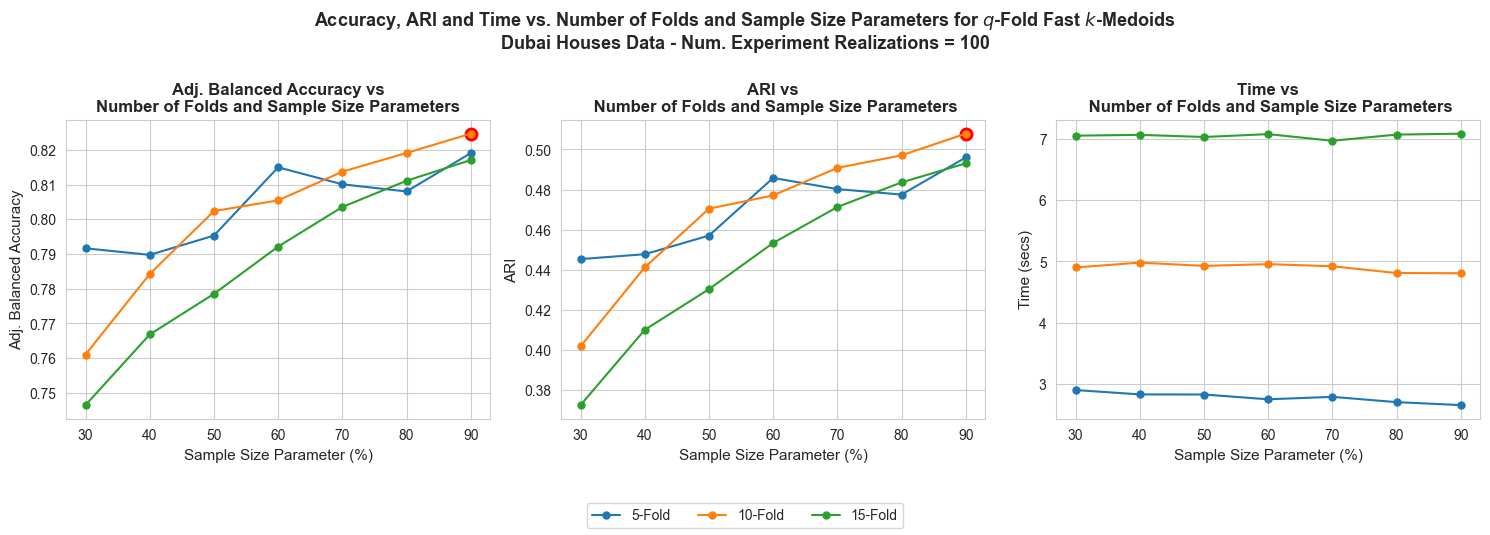

In [43]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Balanced Accuracy vs\nNumber of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Balanced Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nDubai Houses Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_dubai_houses_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [44]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.3,0.791646,0.445349,2.894147
1,5,0.4,0.789762,0.447779,2.822962
2,5,0.5,0.795302,0.457065,2.821132
3,5,0.6,0.814973,0.485795,2.742648
4,5,0.7,0.810078,0.480239,2.782880
5,5,0.8,0.808016,0.477503,2.696046
6,5,0.9,0.819063,0.495993,2.647657
7,10,0.3,0.761063,0.401873,4.901620
8,10,0.4,0.784247,0.441200,4.981408
9,10,0.5,0.802360,0.470462,4.927725


In [45]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.525 
 best_n_splits 10.0 
 best_frac_sample_size 0.9



## Experiment 4

In [10]:
config_exp_4 = get_config_exp_4_dubai_houses()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 100
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state,),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
                                    
        'DipInit': DipInit(n_clusters=config_exp_4['n_clusters'],
                            random_state=random_state),

        'SpectralClustering': SpectralClustering(n_clusters=config_exp_4['n_clusters'],
                                                 random_state=random_state)
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

#################################################################################################      

model_names = list(models[random_state_list[0]].keys())

In [11]:
run_experiment_4 = True

In [12]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'dubai_houses')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251018_215622'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [ ]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=balanced_accuracy_score  # accuracy_score 
                )

        # Save results
        results_filename = f'results_exp_4_dubai_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations:   mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [6863, 35084, 11427]
random_state: 6863
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


len y_pred: 2
random_state: 35084
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


len y_pred: 2
random_state: 11427
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   3%|▎         | 1/34 [01:29<49:08, 89.34s/chunks]

len y_pred: 2
chunk_id 1
random_state_chunk: [53377, 34937, 14116]
random_state: 53377
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


len y_pred: 2
random_state: 34937
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


len y_pred: 2
random_state: 14116
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   6%|▌         | 2/34 [02:59<47:53, 89.81s/chunks]

len y_pred: 2
chunk_id 2
random_state_chunk: [5000, 49692, 70281]
random_state: 5000
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


len y_pred: 2
random_state: 49692
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


len y_pred: 2
random_state: 70281
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   9%|▉         | 3/34 [04:28<46:11, 89.39s/chunks]

len y_pred: 2
chunk_id 3
random_state_chunk: [73704, 43541, 44669]
random_state: 73704
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


len y_pred: 2
random_state: 43541
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


len y_pred: 2
random_state: 44669
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  12%|█▏        | 4/34 [05:57<44:35, 89.19s/chunks]

len y_pred: 2
chunk_id 4
random_state_chunk: [6802, 20927, 17702]
random_state: 6802
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


len y_pred: 2
random_state: 20927
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


len y_pred: 2
random_state: 17702
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  15%|█▍        | 5/34 [08:07<50:14, 103.94s/chunks]

len y_pred: 2
chunk_id 5
random_state_chunk: [44199, 73526, 43751]
random_state: 44199
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


len y_pred: 2
random_state: 73526
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


len y_pred: 2
random_state: 43751
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  18%|█▊        | 6/34 [11:34<1:04:52, 139.01s/chunks]

len y_pred: 2
chunk_id 6
random_state_chunk: [91971, 32134, 21466]
random_state: 91971
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


len y_pred: 2
random_state: 32134
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
random_state: 21466
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  21%|██        | 7/34 [15:03<1:12:50, 161.86s/chunks]

len y_pred: 2
chunk_id 7
random_state_chunk: [218, 57183, 11483]
random_state: 218
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


len y_pred: 2
random_state: 57183
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


len y_pred: 2
random_state: 11483
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  24%|██▎       | 8/34 [16:43<1:01:33, 142.07s/chunks]

len y_pred: 2
chunk_id 8
random_state_chunk: [78328, 49492, 9158]
random_state: 78328
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


len y_pred: 2
random_state: 49492
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
random_state: 9158
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  26%|██▋       | 9/34 [18:16<52:49, 126.78s/chunks]  

len y_pred: 2
chunk_id 9
random_state_chunk: [864, 41347, 95949]
random_state: 864
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


len y_pred: 2
random_state: 41347
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


len y_pred: 2
random_state: 95949
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  29%|██▉       | 10/34 [20:36<52:20, 130.86s/chunks]

len y_pred: 2
chunk_id 10
random_state_chunk: [58762, 13374, 5752]
random_state: 58762
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


len y_pred: 2
random_state: 13374
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


len y_pred: 2
random_state: 5752
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  32%|███▏      | 11/34 [22:50<50:36, 132.04s/chunks]

len y_pred: 2
chunk_id 11
random_state_chunk: [12158, 87443, 18635]
random_state: 12158
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


len y_pred: 2
random_state: 87443
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


len y_pred: 2
random_state: 18635
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  35%|███▌      | 12/34 [24:58<47:57, 130.82s/chunks]

len y_pred: 2
chunk_id 12
random_state_chunk: [16547, 2783, 38247]
random_state: 16547
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
random_state: 2783
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


len y_pred: 2
random_state: 38247
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  38%|███▊      | 13/34 [26:35<42:11, 120.53s/chunks]

len y_pred: 2
chunk_id 13
random_state_chunk: [56444, 75157, 62511]
random_state: 56444
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


len y_pred: 2
random_state: 75157
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


len y_pred: 2
random_state: 62511
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  41%|████      | 14/34 [28:10<37:36, 112.82s/chunks]

len y_pred: 2
chunk_id 14
random_state_chunk: [34776, 61511, 4816]
random_state: 34776
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


len y_pred: 2
random_state: 61511
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
random_state: 4816
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  44%|████▍     | 15/34 [30:26<37:56, 119.79s/chunks]

len y_pred: 2
chunk_id 15
random_state_chunk: [39989, 45018, 68376]
random_state: 39989
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


len y_pred: 2
random_state: 45018
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


len y_pred: 2
random_state: 68376
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  47%|████▋     | 16/34 [32:41<37:19, 124.44s/chunks]

len y_pred: 2
chunk_id 16
random_state_chunk: [63302, 27113, 79810]
random_state: 63302
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


len y_pred: 2
random_state: 27113
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


len y_pred: 2
random_state: 79810
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  50%|█████     | 17/34 [35:09<37:11, 131.27s/chunks]

len y_pred: 2
chunk_id 17
random_state_chunk: [83723, 69084, 74031]
random_state: 83723
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


len y_pred: 2
random_state: 69084
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


len y_pred: 2
random_state: 74031
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  53%|█████▎    | 18/34 [37:13<34:25, 129.10s/chunks]

len y_pred: 2
chunk_id 18
random_state_chunk: [41322, 1644, 52197]
random_state: 41322
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


len y_pred: 2
random_state: 1644
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


len y_pred: 2
random_state: 52197
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  56%|█████▌    | 19/34 [39:09<31:17, 125.20s/chunks]

len y_pred: 2
chunk_id 19
random_state_chunk: [84692, 67207, 56935]
random_state: 84692
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


len y_pred: 2
random_state: 67207
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


len y_pred: 2
random_state: 56935
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  59%|█████▉    | 20/34 [41:01<28:16, 121.20s/chunks]

len y_pred: 2
chunk_id 20
random_state_chunk: [89762, 70584, 83670]
random_state: 89762
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


len y_pred: 2
random_state: 70584
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


len y_pred: 2
random_state: 83670
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  62%|██████▏   | 21/34 [42:41<24:55, 115.04s/chunks]

len y_pred: 2
chunk_id 21
random_state_chunk: [87380, 78185, 63718]
random_state: 87380
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


len y_pred: 2
random_state: 78185
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


len y_pred: 2
random_state: 63718
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  65%|██████▍   | 22/34 [45:20<25:37, 128.10s/chunks]

len y_pred: 2
chunk_id 22
random_state_chunk: [68237, 87617, 54984]
random_state: 68237
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


len y_pred: 2
random_state: 87617
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
random_state: 54984
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  68%|██████▊   | 23/34 [47:16<22:49, 124.46s/chunks]

len y_pred: 2
chunk_id 23
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


len y_pred: 2
random_state: 66855
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


len y_pred: 2
random_state: 4173
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  71%|███████   | 24/34 [49:05<19:57, 119.75s/chunks]

len y_pred: 2
chunk_id 24
random_state_chunk: [98850, 84600, 23784]
random_state: 98850
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


len y_pred: 2
random_state: 84600
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


len y_pred: 2
random_state: 23784
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  74%|███████▎  | 25/34 [51:04<17:56, 119.66s/chunks]

len y_pred: 2
chunk_id 25
random_state_chunk: [95135, 10827, 63819]
random_state: 95135
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


len y_pred: 2
random_state: 10827
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


len y_pred: 2
random_state: 63819
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  76%|███████▋  | 26/34 [53:11<16:13, 121.70s/chunks]

len y_pred: 2
chunk_id 26
random_state_chunk: [86255, 34326, 22298]
random_state: 86255
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


len y_pred: 2
random_state: 34326
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


len y_pred: 2
random_state: 22298
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  79%|███████▉  | 27/34 [54:57<13:38, 116.98s/chunks]

len y_pred: 2
chunk_id 27
random_state_chunk: [43896, 44160, 72640]
random_state: 43896
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


len y_pred: 2
random_state: 44160
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


len y_pred: 2
random_state: 72640
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  82%|████████▏ | 28/34 [56:22<10:45, 107.65s/chunks]

len y_pred: 2
chunk_id 28
random_state_chunk: [51274, 9606, 94779]
random_state: 51274
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


len y_pred: 2
random_state: 9606
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


len y_pred: 2
random_state: 94779
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  85%|████████▌ | 29/34 [58:32<09:31, 114.23s/chunks]

len y_pred: 2
chunk_id 29
random_state_chunk: [59869, 50810, 75126]
random_state: 59869
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


len y_pred: 2
random_state: 50810
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


len y_pred: 2
random_state: 75126
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  88%|████████▊ | 30/34 [1:00:53<08:08, 122.25s/chunks]

len y_pred: 2
chunk_id 30
random_state_chunk: [44054, 2137, 24780]
random_state: 44054
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


len y_pred: 2
random_state: 2137
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


len y_pred: 2
random_state: 24780
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  91%|█████████ | 31/34 [1:02:14<05:29, 109.98s/chunks]

len y_pred: 2
chunk_id 31
random_state_chunk: [76834, 11554, 82354]
random_state: 76834
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


len y_pred: 2
random_state: 11554
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


len y_pred: 2
random_state: 82354
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:425: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:700: RuntimeWarning: overflow encountered in square
  lloyd_iter(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\

len y_pred: 1
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  94%|█████████▍| 32/34 [1:03:39<03:24, 102.33s/chunks]

len y_pred: 2
chunk_id 32
random_state_chunk: [47646, 1681, 46126]
random_state: 47646
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 1
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit


In [ ]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'dubai_houses')
    file_id = '20251018_215622'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_dubai_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_dubai_houses_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [ ]:
# Open merged/joined results 

file_id = '20251018_215622'
results_filename = f'results_exp_4_dubai_houses_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'dubai_houses')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [ ]:
pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [ ]:
'''
avg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}
avg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}
avg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}
'''

"\navg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}\navg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}\navg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}\n"

In [ ]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0
    #avg_results['std_adj_acc'][model_name] = 0
    #avg_results['std_ARI'][model_name] = 0
    #avg_results['std_time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
#std_adj_acc = np.array(list(avg_results['std_adj_acc'].values()))
#std_ari = np.array(list(avg_results['std_ARI'].values()))
#std_time = np.array(list(avg_results['std_time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

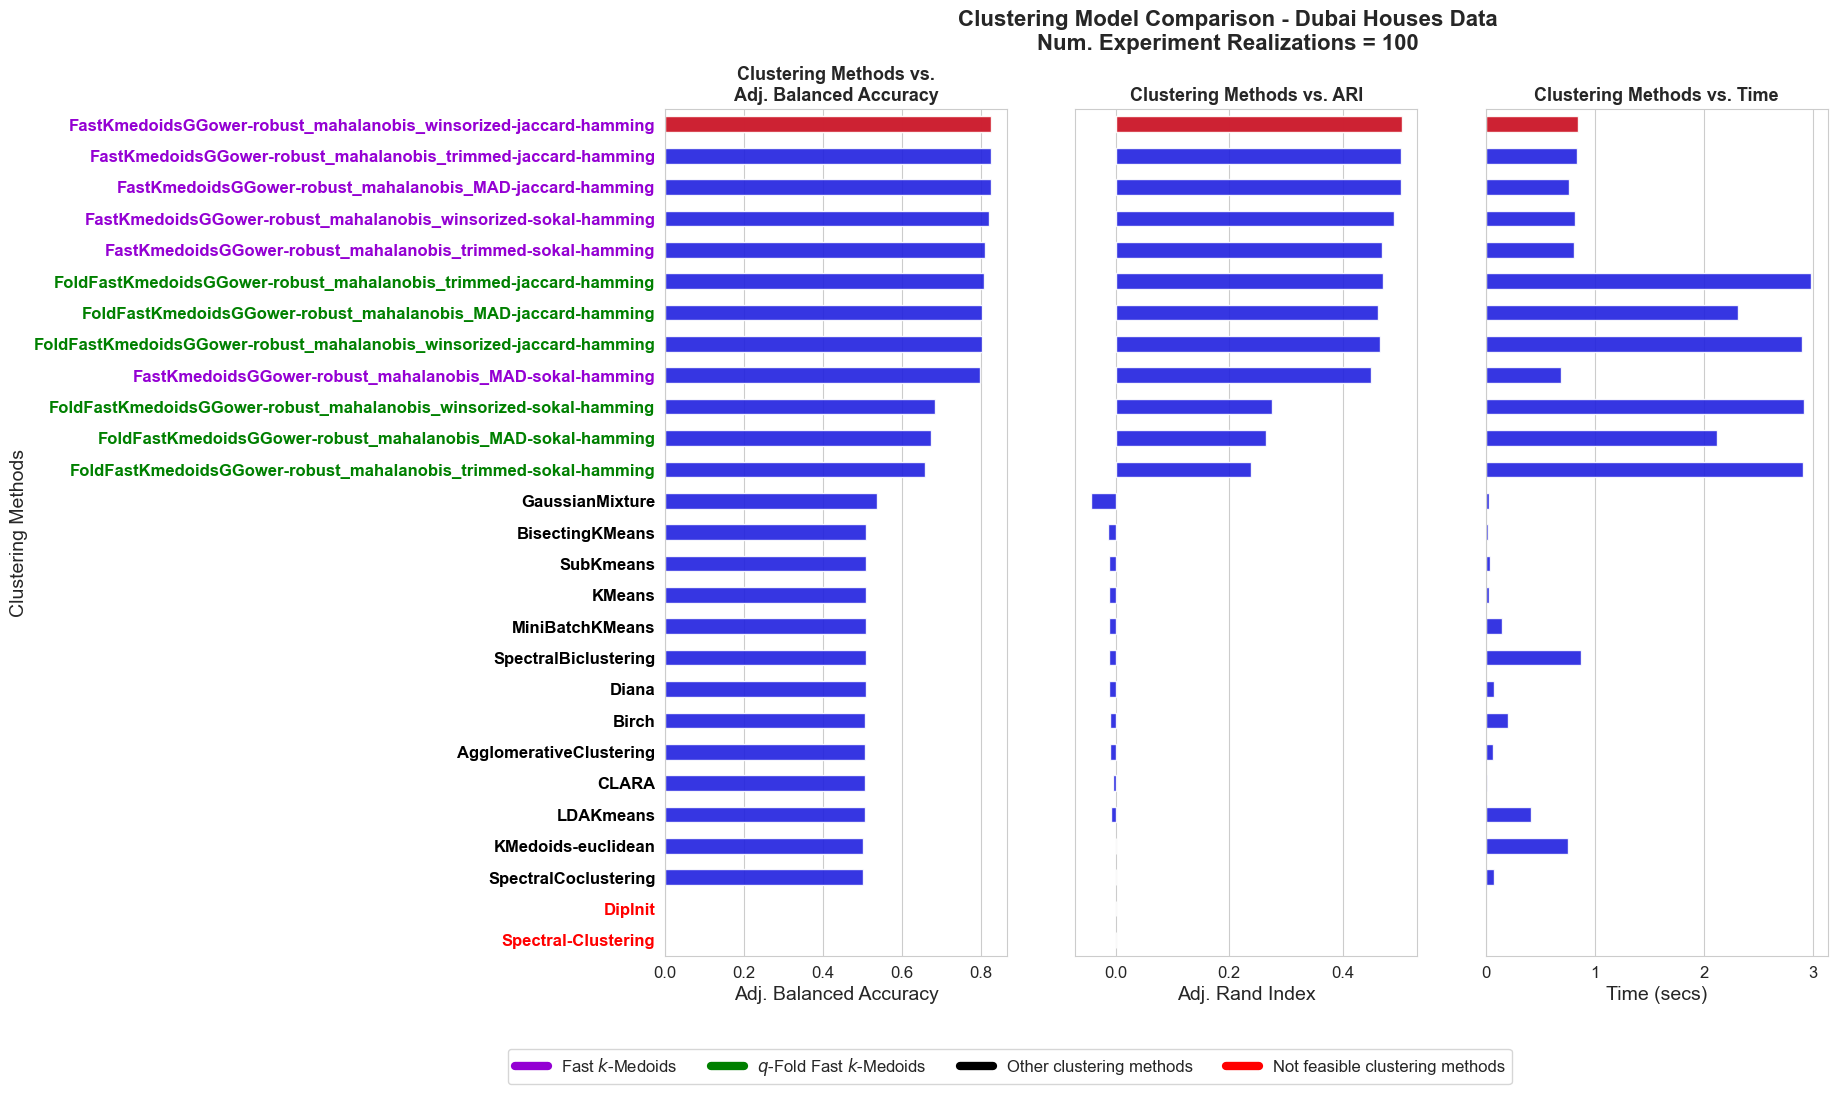

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

'''
# Añadir barras de error manualmente
axes[0].errorbar(
    x=avg_adj_accuracy[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_adj_acc[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[1].errorbar(
    x=avg_ari[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_ari[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[2].errorbar(
    x=avg_time[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_time[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)
'''

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Balanced Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs.\nAdj. Balanced Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Dubai Houses Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_dubai_houses_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [ ]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [ ]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,0.843415,0.823975,0.504125
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,0.832603,0.823854,0.503470
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,0.763614,0.823636,0.502727
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,0.816793,0.820426,0.490154
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,0.812621,0.808165,0.469730
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,2.981593,0.807335,0.470580
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,2.308871,0.800832,0.461645
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,2.893749,0.800655,0.465883
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,0.690429,0.795726,0.449798


In [ ]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI
models,,,
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,0.843415,0.823975,0.504125
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,0.832603,0.823854,0.503470
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,0.763614,0.823636,0.502727
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,0.816793,0.820426,0.490154
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,2.981593,0.807335,0.470580
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,0.812621,0.808165,0.469730
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,2.893749,0.800655,0.465883
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,2.308871,0.800832,0.461645
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,0.690429,0.795726,0.449798


### MDS visualization

In [ ]:
results.keys()

dict_keys([6863, 35084, 11427, 53377, 34937, 14116, 5000, 49692, 70281, 73704, 43541, 44669, 6802, 20927, 17702, 44199, 73526, 43751, 91971, 32134, 21466, 218, 57183, 11483, 78328, 49492, 9158, 864, 41347, 95949, 58762, 13374, 5752, 12158, 87443, 18635, 16547, 2783, 38247, 56444, 75157, 62511, 34776, 61511, 4816, 39989, 45018, 68376, 63302, 27113, 79810, 83723, 69084, 74031, 41322, 1644, 52197, 84692, 67207, 56935, 89762, 70584, 83670, 87380, 78185, 63718, 68237, 87617, 54984, 49089, 66855, 4173, 98850, 84600, 23784, 95135, 10827, 63819, 86255, 34326, 22298, 43896, 44160, 72640, 51274, 9606, 94779, 59869, 50810, 75126, 44054, 2137, 24780, 76834, 11554, 82354, 47646, 1681, 46126, 30032])

In [ ]:
random_state_mds = 6863

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.5, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='jaccard', d3='hamming', 
                 robust_method='trimmed', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [ ]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

KeyError: 2192

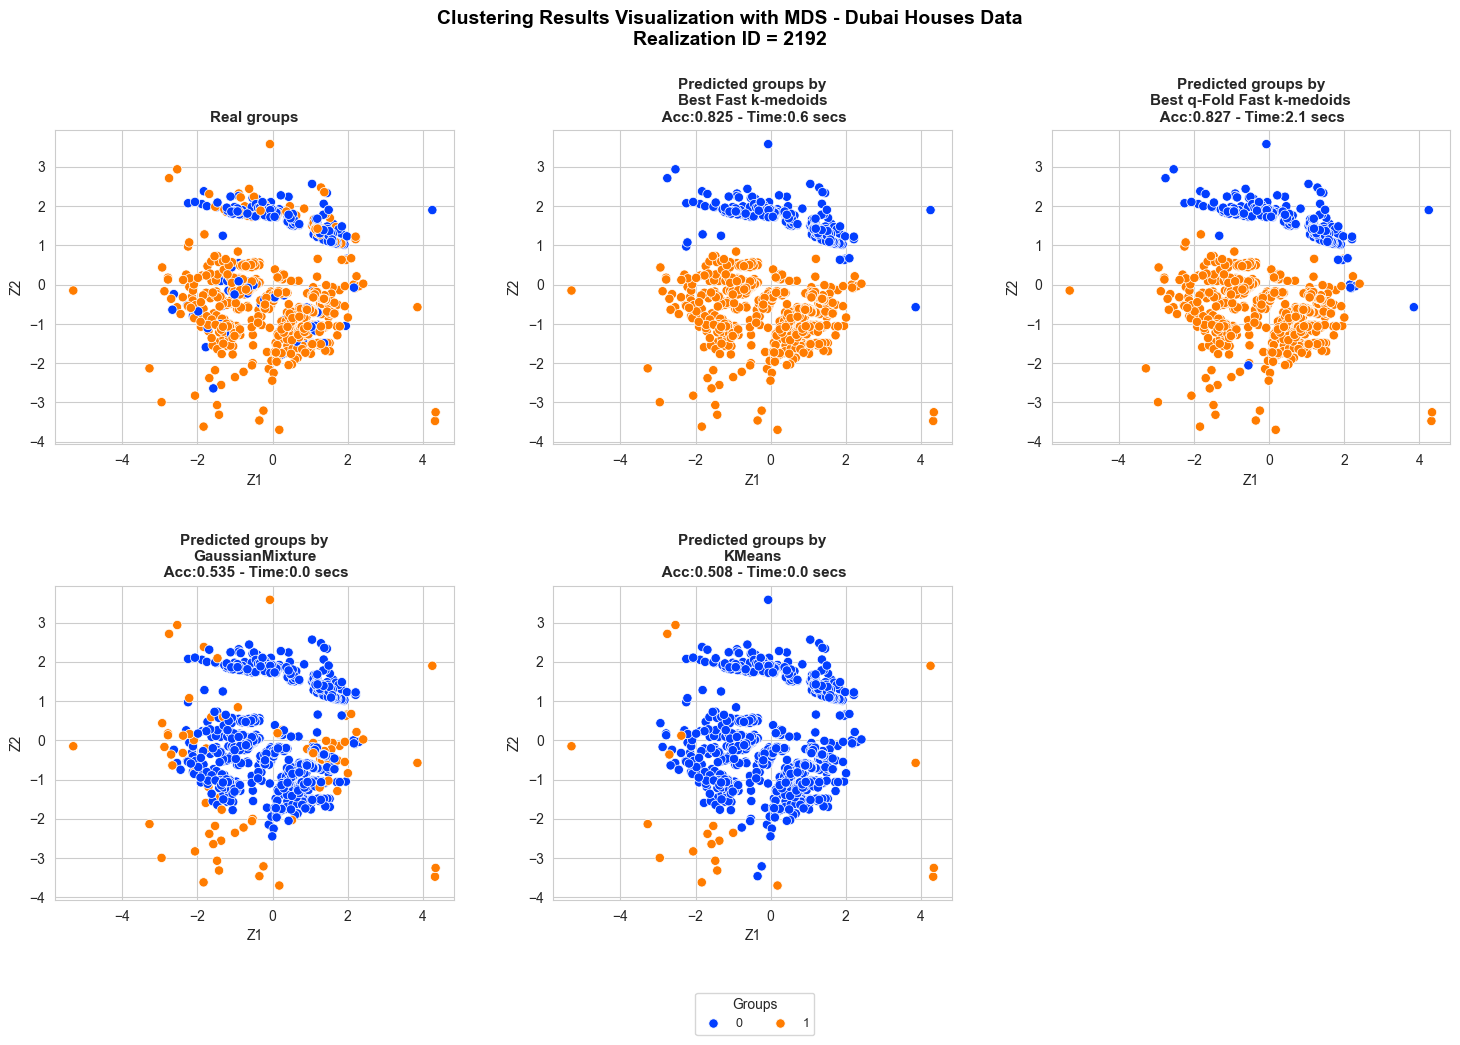

In [ ]:
plot_filename = f'mds_plot_exp_4_kc_houses_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'dubai_houses')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Dubai Houses Data\nRealization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.67,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)